In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
import glob
from labellines import *
from astropy.io import fits
from scipy.stats import linregress
import math

divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 212.
nbins = 64
mmax = 10
nmax = 10

noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

In [2]:
def galaxy_morphology(file):
    
    def FindInc2(eta, A, B, C, D):
        
        if eta>0.5:
            inc=90
        else:
            # 1) Safe inverse argument (A can be negative)
            x = np.clip((eta - D) / A, -1.0, 1.0)

            # 2) Two branches from cos symmetry, all in radians
            a = np.arccos(x)                # in [0, pi]
            i1 = (a - C) / B
            i2 = (-a - C) / B

            # 3) Convert candidates to degrees
            cand = np.rad2deg(np.array([i1, i2]))

            # 4) Reduce by the period in degrees: P = 2π/|B| (then to degrees)
            P = np.rad2deg(2*np.pi / abs(B))
            cand = cand % P                 # map into one period

            # 5) Fold into [0, 180], then reflect >90 across 90 to get [0, 90]
            cand = np.where(cand > 180.0, cand - 180.0, cand)
            cand = np.where(cand > 90.0, 180.0 - cand, cand)

            # 6) Pick the candidate that best reproduces eta (keeps you on the line)
            def model(i_deg):
                return A*np.cos(B*np.deg2rad(i_deg) + C) + D

            errs = np.abs(model(cand) - eta)
            inc=float(cand[np.argmin(errs)])
        return inc
    
    
    with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
    galaxy_name = file.split("-")[0]
    h, w = image_data.shape

    gray=image_data.copy() 
    rmaxx = h // 2
    rmaxy = w // 2
   
    radius=h//4
    cx, cy = w//2, h//2
    y, x = np.indices((h,w))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2
    gray = np.where(mask, gray, 0.0)
    x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
    y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')

    R = np.sqrt(X2**2 + Y2**2).ravel()
    I = image_data.ravel()

    # Filter for positive intensities and R <= 80
    valid = (I > 0) & (R <= 80)
    R_valid = R[valid]
    logI_valid = np.log(I[valid])
   
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
    scale_length = -1 / slope
    if scale_length < 0:
        scale_length = 50
    if scale_length > 100:
        scale_length = 30
    
    a=scale_length*1.5


    x_edges = np.asarray(x_edges).ravel()
    y_edges = np.asarray(y_edges).ravel()

    if x_edges.size < 2 or y_edges.size < 2:
        raise ValueError("Need at least two edges along each axis.")

    # If reversed (common for image-style Y axes), flip them:
    if x_edges[0] > x_edges[-1]:
        x_edges = x_edges[::-1]
    if y_edges[0] > y_edges[-1]:
        y_edges = y_edges[::-1]

    # If they’re not strictly increasing (duplicates), uniquify & sort:
    x_edges = np.unique(x_edges)
    y_edges = np.unique(y_edges)
    D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
    D.img       = gray.T   
    D.x_edges   = x_edges
    D.y_edges   = y_edges
    D.x_centers = x_centers
    D.y_centers = y_centers

    mmax, nmax = 8, 10
    E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)
    
    c1 = E1.coscoefs; s1 = E1.sincoefs
   
    num = np.sqrt(sum((c1[2, n]**2 + s1[2, n]**2) for n in range(nmax)))
    den     = sum(abs(c1[0,n])            for n in range(nmax))

    eta_bt     = num/den
    A=-0.30845928737374684
    B=-1.6564105427131928
    C=6.430938401182824
    D=0.3145522357466893

    inc_bt=FindInc2(eta_bt,A,B,C,D)

    PA=90+(np.arctan2(s1[2,0],c1[2,0])* 180/np.pi)/2

    return inc_bt, PA, galaxy_name
    
Name=[]
Inc=[]
PA=[]
fits_files = glob.glob('gfits3/*.fits.fz')
for idx, file in enumerate(fits_files):
    A=galaxy_morphology(fits_files[idx])
    Name.append(A[2])
    Inc.append(A[0])
    PA.append(A[1])

for idx, name in enumerate(Name):
    print(f"Galaxy: {Name[idx]}, Inclination: {Inc[idx]:.2f}, Position Angle: {PA[idx]:.2f}")

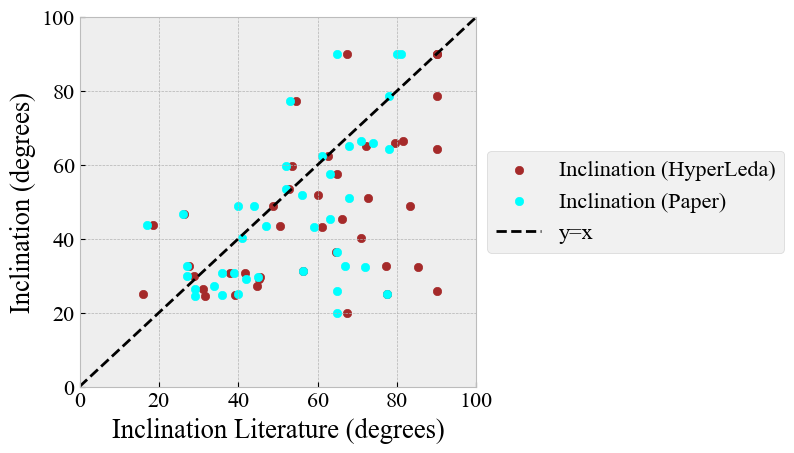

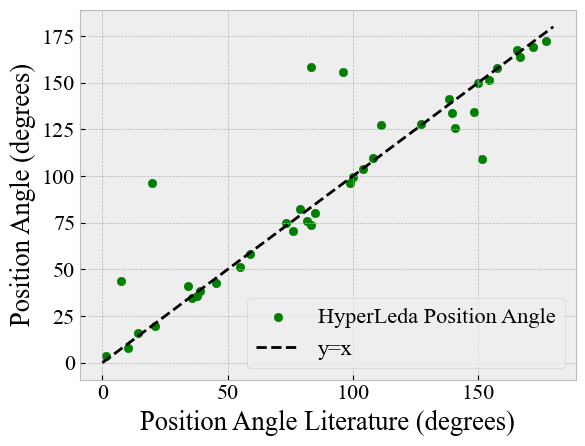

In [3]:
incl = [
    21.54, 38.55, 31.16, 39.33, 73.36, 76.26, 32.85, 53.95, 28.27, 109.75,
    31.55, 27.24, 36.88, 61.25, 73.60, 23.08, 109.75, 57.04, 36.95, 73.03,
    92.74, 109.75, 28.86, 79.60, 54.04, 39.20, 79.38, 37.78, 41.53, 81.25,
    32.77, 109.75, 37.98, 52.61, 109.75, 54.75, 60.89, 45.16, 25.94, 57.67,
    62.91
]
incl_a200 = [
    17.11, 24.35, 41.26, 33.68, 60.17, 69.92, 26.52, 52.17, 6.95, 90.36,
    41.92, 37.20, 45.08, 55.28, 59.07, 27.92, 98.86, 63.03, 26.89, 83.35,
    82.63, 91.20, 25.49, 75.96, 48.68, 32.75, 63.31, 31.43, 46.88, 65.08,
    56.23, 109.75, 43.69, 49.13, 109.75, 63.21, 53.01, 53.64, 39.06, 55.26,
    48.32
]

values = [
    19.82, 29.11, 24.70, 30.70, 66.50, 64.39, 26.50, 43.07, 25.02, 62.29,
    31.18, 25.01, 32.72, 46.67, 65.04, 24.50, 90.00, 43.31, 29.81, 48.75,
    66.02, 90.00, 25.80, 77.28, 43.66, 30.66, 57.64, 29.65, 36.49, 59.70,
    32.27, 78.71, 32.60, 45.27, 90.00, 51.15, 48.81, 40.13, 27.10, 53.52,
    51.70
]

paper_incl = [
    65, 42, 36, 36, 71, 78, 29, 59, 40, 61,
    56.3, 77.6, 27, 26, 68, 29, 65, 47, 27, 40,
    74, 81, 65, 53, 17, 39, 63, 45, 65, 52,
    72, 78, 67, 63, 80, 68, 44, 41, 34, 52,
    56
]

hyperleda_incl = [
    67.4, 45.2, 39.1, 37.9, 81.6, 90, 31.2, 61.1, 16.1, 62.7,
    56.3, 77.6, 27.7, 26.3, 72.1, 31.7, 67.5, 50.5, 28.9, 48.7,
    79.5, 90, 90, 54.5, 18.6, 41.7, 64.8, 45.4, 64.6, 53.6,
    85.3, 90, 77.2, 66.2, 90, 72.7, 83.3, 71, 44.8, 52.7,
    60.1
]

pa = [
    127.42, 96.1, 158.45, 172.61, 103.76, 38.39, 109.37, 43.62, 4.16, 35.9,
    141.5, 51.35, 19.92, 70.78, 74.64, 125.64, 82.5, 15.69, 155.55, 133.96,
    163.58, 167.31, 8.14, 109.7, 147.64, 80.02, 134.47, 34.94, 169.05, 127.71,
    99.43, 149.76, 41, 42.79, 75.95, 3.71, 73.73, 58.08, 151.32, 157.8,
    96.29
]

hyperleda_pa = [
    111.3, 20, 83.4, 177, 104.1, 39, 151.7, 7.5, None, 37.7,
    138.5, 55, 21.2, 75.9, 73.4, 140.9, 79, 14.2, 95.9, 139.4,
    166.8, 165.6, 10.2, 107.9, None, 84.9, 148.3, 35.7, 171.8, 127,
    100, 150, 34, 45.5, 81.7, 1.5, 83.3, 58.9, 154.5, 157.4,
    98.8
]

sqrt_sum_a200 = [
    30.22, 25.75, 16.38, 20.36, 0.79, 6.15, 24.76, 8.80, 34.14, 82.19,
    14.98, 18.33, 12.52, 7.57, 1.35, 23.95, 52.79, 3.86, 24.78, 84.69,
    79.31, 72.17, 24.56, 84.81, 11.51, 19.67, 82.27, 16.22, 8.94, 4.65,
    5.35, 61.81, 10.67, 5.39, 66.22, 0.78, 7.57, 6.34, 13.36, 2.82,
    7.57
]

sqrt_sum_aa = [
    27.31, 17.29, 21.55, 16.47, 74.23, 77.21, 20.15, 3.72, 23.22, 77.99,
    15.50, 21.23, 12.91, 0.69, 77.03, 21.97, 66.22, 2.13, 17.83, 5.16,
    72.12, 52.62, 22.08, 64.77, 3.90, 16.33, 84.87, 16.73, 9.69, 81.09,
    13.63, 59.82, 13.16, 0.15, 66.22, 5.26, 1.58, 6.41, 19.09, 6.96,
    4.57
]

x=np.linspace(0, 180, 100)
fig = plt.figure()
ax = plt.subplot(111)
""" plt.scatter(paper_incl, incl, label='Paper Inclination', color='blue')
plt.scatter(hyperleda_incl, incl, label='HyperLeda Inclination', color='orange')
plt.scatter(hyperleda_incl, incl_a200, label='Inclination a=200', color='red')
plt.scatter(paper_incl, incl_a200, label='Inclination( Paper)', color='purple')"""
plt.scatter(hyperleda_incl, values, label='Inclination (HyperLeda)', color='brown')
plt.scatter(paper_incl, values, label='Inclination (Paper)', color='cyan')
plt.plot(x, x, color='black', linestyle='--', label='y=x')
plt.xlabel('Inclination Literature (degrees)')
plt.ylabel('Inclination (degrees)')
plt.xlim(0, 100)
plt.ylim(0, 100)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.scatter(hyperleda_pa, pa, label='HyperLeda Position Angle', color='green')
plt.plot(x, x, color='black', linestyle='--', label='y=x')
plt.xlabel('Position Angle Literature (degrees)')
plt.ylabel('Position Angle (degrees)')
plt.legend()
plt.show()  

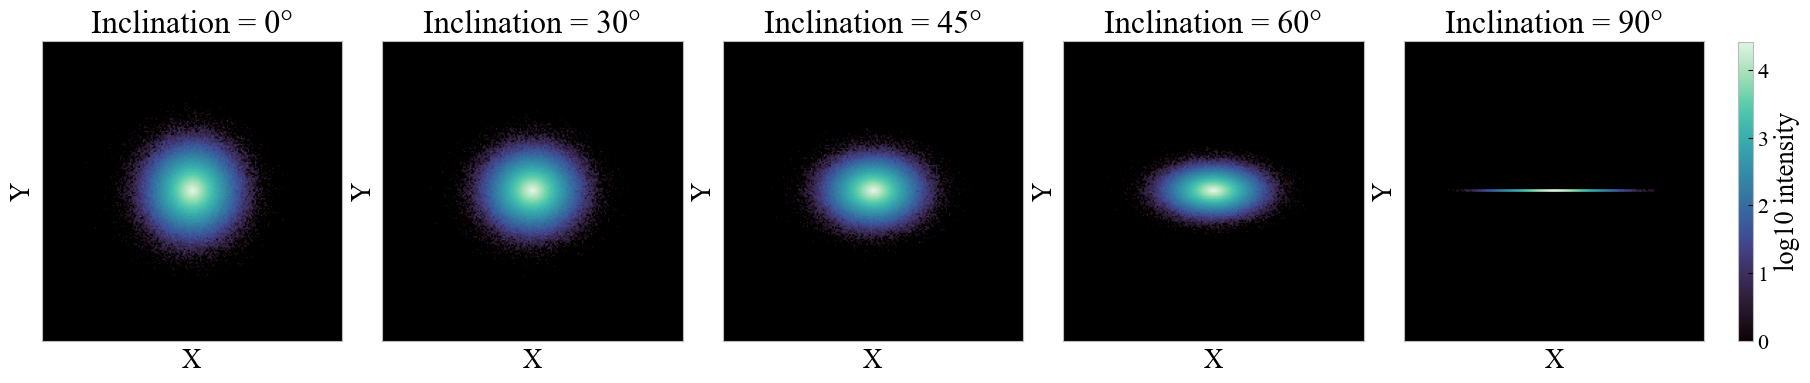

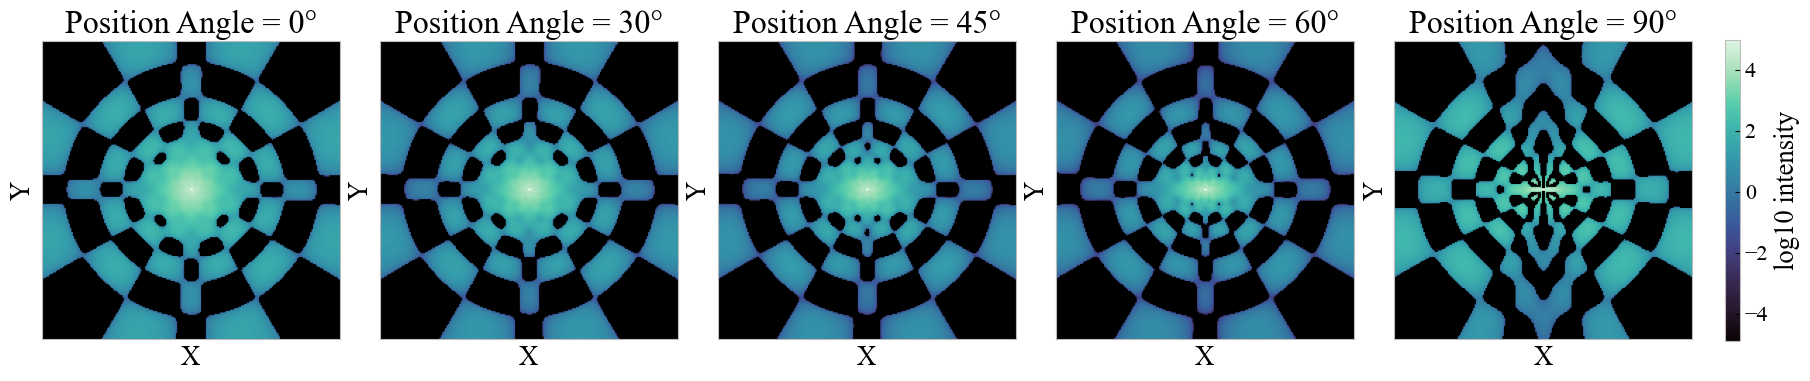

Amn (rows = n, columns = m):
[[ 413.    7.   66.    2.    9.    4.    9.]
 [ 577.    9.   92.    2.   13.    6.   12.]
 [ 696.   11.  110.    3.   16.    7.   15.]
 [ 793.   13.  124.    3.   18.    8.   16.]
 [ 874.   14.  136.    4.   20.    9.   18.]
 [ 944.   15.  146.    4.   21.   10.   19.]
 [1005.   16.  155.    4.   22.   10.   20.]
 [1059.   17.  162.    4.   24.   11.   21.]]


In [4]:
import seaborn as sns
N = 1000000
a = 6                    # reconstruction scale as requested
rmax = 212/2
nbins = 212
noise = 0.0
mmax, nmax = 10, 10
incs = [0, 30, 45, 60, 90]
PAs= [0, 30, 45, 60, 90]  # Position angles in degrees

# precompute grid edges/centers + extent
x_edges = np.linspace(-rmax, rmax, nbins + 1)
y_edges = np.linspace(-rmax, rmax, nbins + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

orig_imgs = []
recon_imgs = []

for PA in PAs:
    # --- simulate & get original image ---
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(PA, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    orig_imgs.append(img_orig)

    # --- Laguerre expansion & reconstruction on the same grid ---
    E1 = D.make_expansion(mmax, nmax, a, noisy=False)
    E1.laguerre_reconstruction(D.r, D.p)   # produces E1.reconstruction on a point set

    # Map reconstruction back to the image grid via histogramming
    X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')
    x_flat = X2.ravel()
    y_flat = Y2.ravel()
    w_flat = E1.reconstruction.ravel()

    recon_img, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges],
        weights=w_flat
    )
    counts, _, _ = np.histogram2d(
        x_flat, y_flat,
        bins=[x_edges, y_edges]
    )

    # avoid divide-by-zero; normalize total flux to the original image
    recon_img = recon_img / np.maximum(counts, 1)
    # match total intensity
    total_recon = np.sum(recon_img)
    if total_recon > 0:
        recon_img *= np.sum(img_orig) / total_recon

    recon_img = recon_img.T  # to match imshow orientation
    recon_imgs.append(recon_img)

cmap=sns.color_palette("mako", as_cmap=True)
# --- plot: originals ---
fig1, axes1 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes1:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes1 = [axes1]
for ax, inc, im in zip(axes1, incs, orig_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Inclination = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")

cbar1 = fig1.colorbar(h, ax=axes1, shrink=0.9, pad=0.02)
cbar1.set_label("log10 intensity")

# --- plot: reconstructions (a = 60) ---
fig2, axes2 = plt.subplots(1, len(incs), figsize=(3.6*len(incs), 3.6), constrained_layout=True)
for ax in axes2:
    ax.set(facecolor = "black")
if len(incs) == 1:
    axes2 = [axes2]
for ax, inc, im in zip(axes2, incs, recon_imgs):
    imshow_data = np.log10(np.where(im > 0, im, np.nan))
    h = ax.imshow(imshow_data.T, extent=extent, cmap=cmap, origin='lower')
    ax.set_title(f"Position Angle = {inc}°")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("X"); ax.set_ylabel("Y")


cbar2 = fig2.colorbar(h, ax=axes2, shrink=0.9, pad=0.02)
cbar2.set_label("log10 intensity")

plt.show()
nmax=8
mmax=6
N=10000
a=6
D = DiscGalaxy(N=N, a=a, M=3951.4895 )
D.rotate_disc(30, 0, 40)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()
orig_imgs.append(img_orig)

# --- Laguerre expansion & reconstruction on the same grid ---
E = D.make_pointexpansion(mmax, nmax, a, noisy=False)
E.laguerre_reconstruction(D.r, D.p)



coscoefs = E.coscoefs
sincoefs = E.sincoefs

Amn = np.sqrt(E.coscoefs**2 + E.sincoefs**2) 

Amn_matrix = Amn.T 

# Print matrix
print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,0)) 





In [5]:
incl_list = np.linspace(0, 85, 30)   # inclinations to sample
PA_list   = np.linspace(0, 90, 2)    # PAs to sample
colorindx = np.linspace(0, 1, len(incl_list) + 1)  # FIX: len(incl_list)+1
file=fits_files[3]
with fits.open(file) as hdulist:
        image_data = hdulist[1].data
        
galaxy_name = file.split("-")[0]
h, w = image_data.shape

gray=image_data.copy() 
rmaxx = h // 2
rmaxy = w // 2

radius=h//4
cx, cy = w//2, h//2
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
gray = np.where(mask, gray, 0.0)
x_edges = np.linspace(-rmaxy, rmaxy, w + 1)
y_edges = np.linspace(-rmaxx, rmaxx, h + 1)
x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
X2, Y2 = np.meshgrid(x_centers, y_centers, indexing='ij')

R = np.sqrt(X2**2 + Y2**2).ravel()
I = image_data.ravel()

# Filter for positive intensities and R <= 80
valid = (I > 0) & (R <= 80)
R_valid = R[valid]
logI_valid = np.log(I[valid])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(R_valid, logI_valid)
scale_length = -1 / slope
if scale_length < 0:
    scale_length = 50
if scale_length > 100:
    scale_length = 30

a=scale_length*1.5
a=200

x_edges = np.asarray(x_edges).ravel()
y_edges = np.asarray(y_edges).ravel()

if x_edges.size < 2 or y_edges.size < 2:
    raise ValueError("Need at least two edges along each axis.")

# If reversed (common for image-style Y axes), flip them:
if x_edges[0] > x_edges[-1]:
    x_edges = x_edges[::-1]
if y_edges[0] > y_edges[-1]:
    y_edges = y_edges[::-1]

# If they’re not strictly increasing (duplicates), uniquify & sort:
x_edges = np.unique(x_edges)
y_edges = np.unique(y_edges)
D = DiscGalaxy(N=N,a=a,M=np.sum(gray))   
D.img       = gray.T   
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

mmax, nmax = 8, 8
E1 = D.make_expansion(mmax, nmax, a*1.5, noisy=False)

c1 = E1.coscoefs; s1 = E1.sincoefs

num     = sum(np.hypot(c1[2,n], s1[2,n]) for n in range(nmax))
den     = sum(abs(c1[0,n])            for n in range(nmax))

eta_bt     = num/den
plt.figure(figsize=(9, 6))
eta_avg_list = []
for i, inc in enumerate(incl_list):
    etas, eta_cos_list, eta_sin_list = [], [], []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=np.sum(gray))
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=min(rmaxx, rmaxy), nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        denom   = sum(abs(coscoefs[0, n]) for n in range(nmax)) or np.nan
        num     = np.sqrt(sum((coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax)))
        num_cos = np.sign(coscoefs[2, 0]) * sum(abs(coscoefs[2, n]) for n in range(nmax))
        num_sin = np.sign(sincoefs[2, 0]) * sum(abs(sincoefs[2, n]) for n in range(nmax))

        eta     = num / denom
        eta_cos = num_cos / denom
        eta_sin = num_sin / denom
        

        etas.append(eta)
        eta_cos_list.append(eta_cos)
        eta_sin_list.append(eta_sin)

    eta_avg = np.nanmean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(etas, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))

plt.xlabel(r"$\eta$")
labelLines(plt.gca().get_lines(), align=False, fontsize=12)
plt.ylabel(r"$\eta_{\cos}$")
plt.title(r"$\eta_{\cos}$ vs $\eta$")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7) Fit eta_avg(incl) with A cos(B*deg + C) + D
# ------------------------------------------------------------
def cos_function(x_deg, A, B, C, D):
    return A * np.cos(B * np.radians(x_deg) + C) + D

initial_guess = [7.7, 0.01, 2*np.pi, 0.0]
params, covariance = curve_fit(cos_function, incl_list, eta_avg_list, p0=initial_guess, maxfev=20_000)
A_fit, B_fit, C_fit, D_fit = params
print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}")

inc_fit = np.linspace(0.0, 90.0, 500)
A=-0.30845928737374684
B=-1.6564105427131928
C=6.430938401182824

D=0.3145522357466893

eta_fit = cos_function(inc_fit, A, B, C, D)

# ------------------------------------------------------------
# 8) Blind-test eta from observed image coefficients
# ------------------------------------------------------------
den_bt = sum(abs(c1[0, n]) for n in range(nmax)) or np.nan
num_bt = np.sqrt(sum((c1[2, n]**2 + s1[2, n]**2) for n in range(nmax)))
num_cos_bt = np.sign(c1[2, 0]) * sum(abs(c1[2, n]) for n in range(nmax))
num_sin_bt = np.sign(s1[2, 0]) * sum(abs(s1[2, n]) for n in range(nmax))

eta_bt     = num_bt / den_bt
eta_cos_bt = num_cos_bt / den_bt
eta_sin_bt = num_sin_bt / den_bt
print("Blind-test (eta, eta_cos, eta_sin) =", eta_bt, eta_cos_bt, eta_sin_bt)

def FindInc2(eta, A, B, C, D):
    inside = np.clip((eta - D)/A, -1.0, 1.0)
    th = np.arccos(inside)                # in [0, π]
    # both branches for B*i_rad + C:
    cand = np.array([th, -th]) - C
    # convert to degrees of i
    incs = np.degrees(cand / B)
    # fold to physical range [0, 90]
    incs = np.mod(incs, 360.0)            # [0,360)
    incs = np.where(incs > 180, 360 - incs, incs)  # [0,180]
    incs = np.where(incs >  90, 180 - incs, incs)  # [0, 90]
    # choose the candidate whose forward model matches eta best
    errs = np.abs(A*np.cos(B*np.radians(incs) + C) + D - eta)
    return float(incs[np.argmin(errs)])
def FindInc2(eta, A, B, C, D):
    return np.rad2deg(np.arccos((np.clip((eta - D) / A, 0, 1.0)))-C) / B
def FindInc2(eta, A, B, C, D):
    val = np.clip((eta - D) / A, 0, 1.0)
    ang = np.rad2deg(np.arccos(val) - C) / B
    # Force into [0, 90]
    return np.abs((ang + 90) % 180 - 90)

def FindInc2(eta, A, B, C, D):
    # invert the cosine model  η = A*cos( deg2rad(B*i + C) ) + D
    val = np.clip((eta - D) / A, 0.0, 1.0)
    theta = np.rad2deg(np.arccos(val))        # principal angle in [0,180] for the cosine argument

    # Build candidate angles for the cosine argument that are equivalent (same cos)
    # using even symmetry and 360° periodicity.
    base = [theta, -theta, 360 - theta]       # cos(θ) = cos(-θ) = cos(360-θ)
    candidates = []

    for th in base:
        for k in range(-3, 4):                 # add multiples of 360° to cover possibilities
            ang = th + 360.0 * k               # angle of (B*i + C) in degrees
            inc = (ang - C) / B                # solve for i (can be any real)
            if 0.0 <= inc <= 90.0:             # keep only those in [0,90]
                candidates.append(inc)

    if candidates:
        # If multiple, pick the one closest to the “natural” solution.
        inc0 = (theta - C) / B
        return min(candidates, key=lambda x: abs(x - inc0))

    # Fallback (very unlikely): fold by period of i without changing eta too much
    period_i = 360.0 / abs(B)
    inc_fold = ( ( (theta - C) / B ) % period_i )
    return inc_fold if inc_fold <= 90.0 else period_i - inc_fold
A=-0.30845928737374684
B=-1.6564105427131928
C=6.430938401182824

D=0.3145522357466893


inc_bt=FindInc2(eta_bt,A,B,C,D)

print(f"Inclination estimate from fit: {inc_bt:.2f} deg")

plt.figure(figsize=(8, 5))
plt.scatter(incl_list, eta_avg_list, label='Sample (avg over PA)')
plt.plot(inc_fit, eta_fit, label='Fit', linewidth=2)
plt.scatter([inc_bt], [eta_bt], color='red', label=f'Blind test inc ≈ {inc_bt:.0f}°', zorder=5)
plt.xlabel('Inclination (deg)')
plt.ylabel('eta (avg)')
plt.title('Cosine Fit to η vs Inclination')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9) Estimate PA by scanning PAs at the fitted inclination
# ------------------------------------------------------------
PA=90-np.arctan2(s1[2,0], c1[2,0])* 180/np.pi/2
print(f'galaxy_name: {galaxy_name}')

IndexError: list index out of range